In [1]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt
from mne.decoding import CSP
import joblib


In [2]:
# Read and preprocess data
def read_data(path, event_id):
    raw = mne.io.read_raw_brainvision(path, eog=['hEOG_L','hEOG_R','vEOG_U','vEOG_D'])
    raw.drop_channels(['hEOG_L','hEOG_R','vEOG_U','vEOG_D','EMG_1','EMG_2','EMG_3','EMG_4','EMG_5','EMG_6','EMG_ref'])
    events, event_dict = mne.events_from_annotations(raw)
    epoch = mne.Epochs(raw, events, event_id=event_id, tmin=-0.5, tmax=2, baseline=(-0.5,0))
    labels = epoch.events[:, -1]
    data = epoch.get_data()
    return data, labels

In [3]:
# Define file paths
paths = [
    
    r"C:\Users\MrSus\OneDrive\Desktop\EEG and EMG classification\session1_sub11_reaching_MI.vhdr"
]
event_id = [11, 21, 31, 41, 51, 61]
full_labels = []
full_data = []

for path in paths:
    data, labels = read_data(path, event_id)
    full_labels.append(labels)
    full_data.append(data)

full_data = np.vstack(full_data)
full_labels = np.hstack(full_labels)

Extracting parameters from C:\Users\MrSus\OneDrive\Desktop\EEG and EMG classification\session1_sub11_reaching_MI.vhdr...
Setting channel info structure...


C:\Users\MrSus\AppData\Local\Temp\ipykernel_18404\762549213.py:3: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(path, eog=['hEOG_L','hEOG_R','vEOG_U','vEOG_D'])
C:\Users\MrSus\AppData\Local\Temp\ipykernel_18404\762549213.py:3: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(path, eog=['hEOG_L','hEOG_R','vEOG_U','vEOG_D'])
C:\Users\MrSus\AppData\Local\Temp\ipykernel_18404\762549213.py:3: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1250.00 Hz, Nyquist limit) will be stored.
  raw = mne.io.read_raw_brainvision(path, eog=['hEOG_L','hEOG_R','vEOG_U','vEOG_D'])


Used Annotations descriptions: ['Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 300 events and 6251 original time points ...
0 bad epochs dropped


In [4]:
# Bandpass filter
def bandpass(trials, lo, hi, sample_rate):
    a, b = butter(4, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)], btype='band')
    trials_filt = np.zeros(trials.shape)
    for i in range(trials.shape[0]):
        trials_filt[i, :, :] = filtfilt(a, b, trials[i, :, :], axis=1)
    return trials_filt

filtered_data = bandpass(full_data, 8, 30, 250)

In [5]:
# Feature extraction using CSP
csp = CSP(n_components=60, reg=None, log=True, norm_trace=False)
features = csp.fit_transform(filtered_data, full_labels)

# Save CSP model
joblib.dump(csp, 'csp_model.pkl')

# Data normalization
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Save scaler
joblib.dump(scaler, 'scaler_model.pkl')

# Label encoding
lb = LabelEncoder()
encoded_labels = lb.fit_transform(full_labels)

Computing rank from data with rank=None
    Using tolerance 4.1e-05 (2.2e-16 eps * 60 dim * 3.1e+09  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.9e-05 (2.2e-16 eps * 60 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 60 dim * 3e+09  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.3e-05 (2.2e-16 eps * 60 dim * 3.2e+09  max singular value)
    

In [46]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.5, random_state=42, stratify=encoded_labels)

# Reshape data for LSTM input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM Model
def build_lstm_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]), len(np.unique(y_train)))

In [47]:
# Callbacks for early stopping and best model checkpoint
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

# Evaluate the model
model.load_weights('best_model.h5')
_, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Epoch 1/300
3/3 [==============================] - 3s 313ms/step - loss: 1.7971 - accuracy: 0.1400 - val_loss: 1.7832 - val_accuracy: 0.2667
Epoch 2/300
3/3 [==============================] - 0s 28ms/step - loss: 1.7737 - accuracy: 0.3467 - val_loss: 1.7725 - val_accuracy: 0.3467
Epoch 3/300
3/3 [==============================] - 0s 30ms/step - loss: 1.7595 - accuracy: 0.4933 - val_loss: 1.7621 - val_accuracy: 0.4067
Epoch 4/300
1/3 [=========>....................] - ETA: 0s - loss: 1.7447 - accuracy: 0.4531

c:\Users\MrSus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 28ms/step - loss: 1.7393 - accuracy: 0.5267 - val_loss: 1.7514 - val_accuracy: 0.4467
Epoch 5/300
3/3 [==============================] - 0s 27ms/step - loss: 1.7197 - accuracy: 0.6533 - val_loss: 1.7398 - val_accuracy: 0.4467
Epoch 6/300
3/3 [==============================] - 0s 30ms/step - loss: 1.6990 - accuracy: 0.6467 - val_loss: 1.7274 - val_accuracy: 0.4667
Epoch 7/300
3/3 [==============================] - 0s 28ms/step - loss: 1.6807 - accuracy: 0.6467 - val_loss: 1.7136 - val_accuracy: 0.4800
Epoch 8/300
3/3 [==============================] - 0s 19ms/step - loss: 1.6530 - accuracy: 0.6800 - val_loss: 1.6988 - val_accuracy: 0.4800
Epoch 9/300
3/3 [==============================] - 0s 19ms/step - loss: 1.6260 - accuracy: 0.6733 - val_loss: 1.6824 - val_accuracy: 0.4800
Epoch 10/300
3/3 [==============================] - 0s 19ms/step - loss: 1.5930 - accuracy: 0.6867 - val_loss: 1.6645 - val_accuracy: 0.4733
Epoch 11/300
3/3 [=============

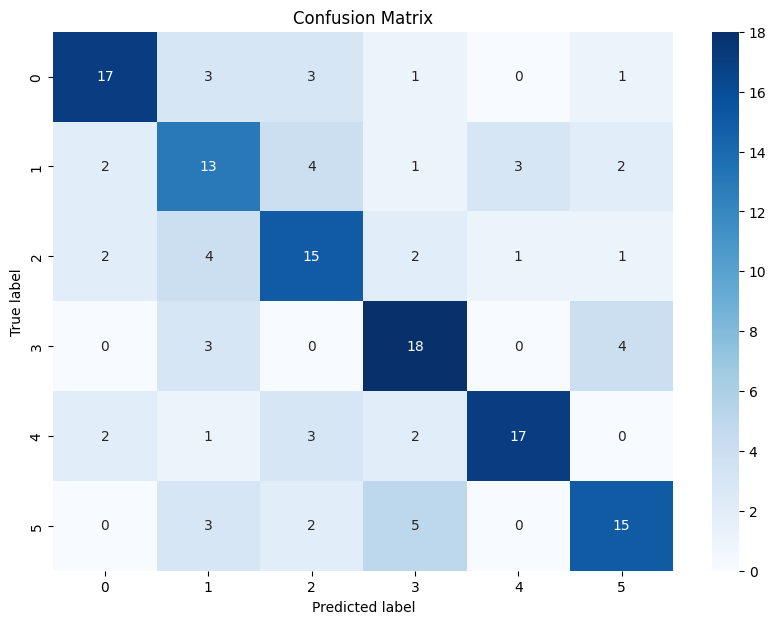

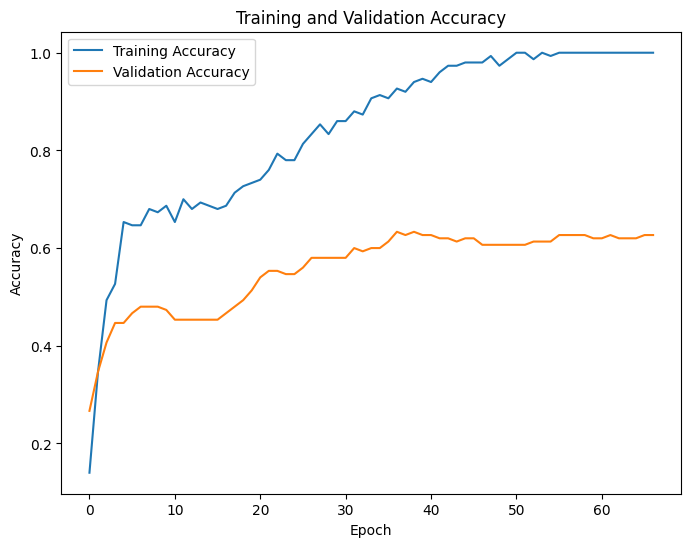

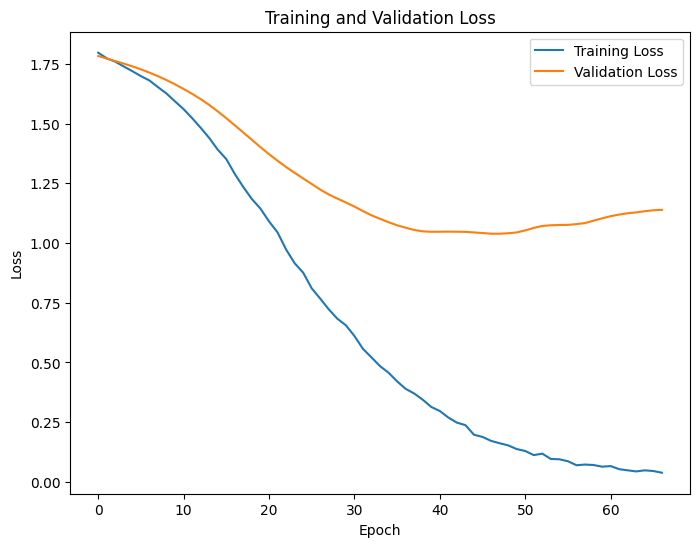

In [50]:
# Confusion Matrix
import seaborn as sns

# Assuming y_test and y_pred_classes are already defined
cm = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Loss plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

report = classification_report(y_test, y_pred_classes, target_names=[str(cls) for cls in lb.classes_])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Print accuracy
print(f'Accuracy: {accuracy*100:.2f}%')


# Convert class labels to strings for the classification report
class_names = [str(cls) for cls in lb.classes_]

# Generate the classification report
report = classification_report(y_test, y_pred_classes, target_names=class_names)

# Print the classification report
print(report)



Accuracy: 63.33%
              precision    recall  f1-score   support

          11       0.74      0.68      0.71        25
          21       0.48      0.52      0.50        25
          31       0.56      0.60      0.58        25
          41       0.62      0.72      0.67        25
          51       0.81      0.68      0.74        25
          61       0.65      0.60      0.63        25

    accuracy                           0.63       150
   macro avg       0.64      0.63      0.64       150
weighted avg       0.64      0.63      0.64       150

